In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

plt.style.use('classic')

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import Activation, Dropout, Flatten, Dense
#from keras import backend as K
import os
import cv2
from PIL import Image
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import cv2
import numpy as np
import os
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
import keras
from keras.models import Sequential, Model, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from google.colab.patches import cv2_imshow
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D, MaxPool2D
from keras.preprocessing import image
from keras.initializers import glorot_uniform
from tensorflow.keras.applications import VGG16
from keras import Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import categorical_crossentropy
from sklearn.model_selection import train_test_split

In [ ]:
SIZE = 224
dataset = []
label = []
Autistic_images = os.listdir("/content/drive/MyDrive/Autism/data/test/Autistic/")
for image_name in (Autistic_images):
  image = cv2.imread("/content/drive/MyDrive/Autism/data/test/Autistic/"+image_name)
  image = Image.fromarray(image, 'RGB')
  image = image.resize((SIZE, SIZE))
  dataset.append(np.array(image))
  label.append(0)

In [ ]:
Nonautistic_images = os.listdir("/content/drive/MyDrive/Autism/data/test/Non_Autistic/")
for image_name in Nonautistic_images:
  image = cv2.imread("/content/drive/MyDrive/Autism/data/test/Non_Autistic/"+image_name)
  image = Image.fromarray(image, 'RGB')
  image = image.resize((SIZE, SIZE))
  dataset.append(np.array(image))
  label.append(1)

In [ ]:
from tensorflow.keras.utils import to_categorical
dataset = np.array(dataset)
label = to_categorical(np.array(label))
print(dataset.shape, label.shape)

(280, 224, 224, 3) (280, 2)


In [ ]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
X_train, X_test, y_train, y_test = train_test_split(dataset, label, test_size = 0.20, random_state = 0)
X_train = tf.keras.utils.normalize(X_train, axis=1)
X_test = tf.keras.utils.normalize(X_test, axis=1)

In [ ]:
base_model = VGG16(weights = 'imagenet', include_top = False, input_shape = (224,224,3), pooling = 'avg')
for layers in base_model.layers:
  layers.trainable = False
headModel = base_model.output
headModel = Flatten()(headModel)
headModel = Dense(256, activation='relu', name="fci", kernel_initializer=glorot_uniform(seed=0)) (headModel)
headModel = Dense(118, activation='relu', name="fc2", kernel_initializer=glorot_uniform(seed=0)) (headModel)
headModel = Dense(2, activation='softmax', name="fc3", kernel_initializer=glorot_uniform(seed=0)) (headModel)
VGG16_model = Model(inputs=base_model.input, outputs = headModel)
VGG16_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((224, 224, 224, 3), (56, 224, 224, 3), (224, 2), (56, 2))

In [ ]:
from tensorflow.keras import backend as K

def recall_m(y_true,y_pred):
  true_positives = K.sum(K.round(K.clip(y_true * y_pred,0,1)))
  possible_positives = K.sum(K.round(K.clip(y_true,0,1)))
  recall = true_positives / (possible_positives + K.epsilon())
  return recall

def precision_m(y_true,y_pred):
  true_positives = K.sum(K.round(K.clip(y_true * y_pred,0,1)))
  predicted_positives = K.sum(K.round(K.clip(y_pred,0,1)))
  precision = true_positives / (predicted_positives + K.epsilon())
  return precision

def f1_m(y_true,y_pred):
  precision = precision_m(y_true,y_pred)
  recall = recall_m(y_true,y_pred)
  return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
opt = Adam(learning_rate=0.01)
VGG16_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy', recall_m, precision_m, f1_m])

In [ ]:
#os.chdir('/content/drive/MyDrive/Colab Notebooks/Vgg16/VGG16_ASD')
VGG16_history = VGG16_model.fit(X_train,y_train,validation_data=(X_test,y_test),batch_size=32,epochs=10)
#VGG16_model.save('Vgg16')

Epoch 1/10
7/7 [==============================] - 184s 26s/step - loss: 0.7066 - accuracy: 0.4866 - recall_m: 0.4866 - precision_m: 0.4866 - f1_m: 0.4866 - val_loss: 0.6908 - val_accuracy: 0.5000 - val_recall_m: 0.5052 - val_precision_m: 0.5052 - val_f1_m: 0.5052
Epoch 2/10
7/7 [==============================] - 175s 26s/step - loss: 0.6952 - accuracy: 0.5179 - recall_m: 0.5179 - precision_m: 0.5179 - f1_m: 0.5179 - val_loss: 0.6921 - val_accuracy: 0.5000 - val_recall_m: 0.4948 - val_precision_m: 0.4948 - val_f1_m: 0.4948
Epoch 3/10
7/7 [==============================] - 169s 25s/step - loss: 0.6879 - accuracy: 0.5580 - recall_m: 0.5580 - precision_m: 0.5580 - f1_m: 0.5580 - val_loss: 0.6837 - val_accuracy: 0.5536 - val_recall_m: 0.5625 - val_precision_m: 0.5625 - val_f1_m: 0.5625
Epoch 4/10
7/7 [==============================] - 175s 26s/step - loss: 0.6928 - accuracy: 0.5179 - recall_m: 0.5179 - precision_m: 0.5179 - f1_m: 0.5179 - val_loss: 0.6802 - val_accuracy: 0.6786 - val_recall

In [ ]:
VGG16_model.evaluate(dataset,label)

9/9 [==============================] - 170s 19s/step - loss: 2.9654 - accuracy: 0.5179 - recall_m: 0.5046 - precision_m: 0.5046 - f1_m: 0.5046


[2.9654462337493896,
 0.5178571343421936,
 0.5046296119689941,
 0.5046296119689941,
 0.5046296119689941]

In [ ]:
y_pred = VGG16_model.predict(X_test)
for i in range(len(y_pred)):
  arg_max_val = np.argmax(y_pred[i])
  y_pred[i] = 0
  y_pred[i][arg_max_val] = 1
print(y_pred[0])
print(y_test[0])

2/2 [==============================] - 38s 15s/step
[0. 1.]
[0. 1.]


In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
print(cm)

[[26  2]
 [12 16]]


<Axes: >

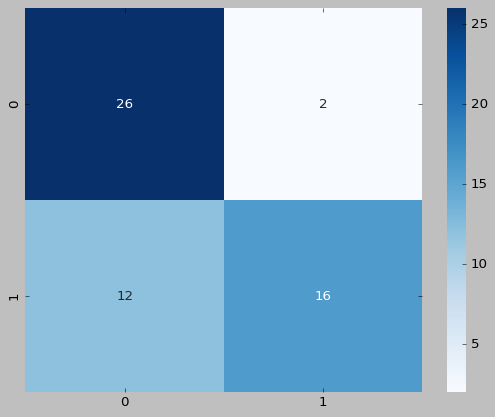

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.heatmap(cm,annot=True,fmt='d',cmap='Blues')

In [ ]:
from sklearn import metrics
print(metrics.classification_report(y_test,y_pred,digits=3))

              precision    recall  f1-score   support

           0      0.684     0.929     0.788        28
           1      0.889     0.571     0.696        28

   micro avg      0.750     0.750     0.750        56
   macro avg      0.787     0.750     0.742        56
weighted avg      0.787     0.750     0.742        56
 samples avg      0.750     0.750     0.750        56



1/1 [==============================] - 1s 587ms/step
Predicted label: Autistic
Actual label: Autistic


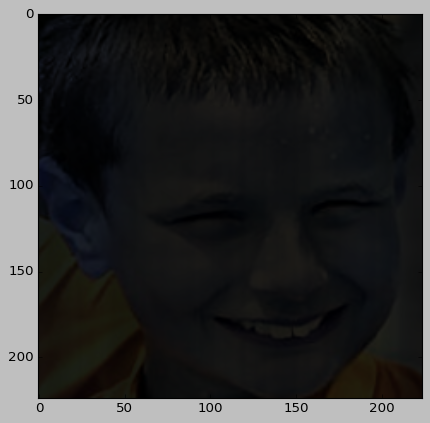

In [ ]:
import numpy as np
img_num = 50
img = X_test[img_num]
plt.imshow(img)
input_img = np.expand_dims(img, axis=0)
prediction = np.array(VGG16_model.predict(input_img))
predicted_class = np.argmax(prediction)
class_labels = ['Autistic','Non-Autistic']
actual_class = np.argmax(y_test[img_num])
pre_class = class_labels[predicted_class]
ac_class = class_labels[actual_class]
print("Predicted label:",pre_class)
print("Actual label:",ac_class)